In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
import seaborn as sns
from itertools import chain
import os
import gmaps
import gmaps.datasets
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
headers = ['url', 'price', 'partial_title', 'geo_lat', 'geo_long', 'rating',
           'number_reviews', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
           'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
           'title', 'description', 'distance_to_TS_meter', 'distance_to_TS']

data_file = 'data/homeaway_rentals_nyc_PARSED.csv' 
df = pd.read_csv(data_file, sep='\t', header=0, names=headers, index_col=0)
df[['description']] = df[['description']].fillna(value='')

# Try modeling only with nightly prices under $8000
percent_under_800 = 100 * (df.loc[df.price < 800].shape[0] / df.shape[0])
print('Percentage of rentals under $800:', percent_under_800)
print('Dropping ', df.loc[df.price >= 800].shape[0], ' data points')
df = df.loc[df.price < 800]

Percentage of rentals under $800: 94.88132685158708
Dropping  179  data points


In [3]:
# do some feature engineering
df['text_clean'] = df['title'].map(str) + ' ' + df["description"]
df['text_clean'] = df['text_clean'].str.replace(r'[:\*,\.]', '')
df['text_clean'] = df['text_clean'].str.strip()

df['text_onefinestay'] = df['text_clean'].str.contains(" onefinestay ")
df['text_master'] = df['text_clean'].str.contains(" master ")
df['text_requests'] = df['text_clean'].str.contains(" requests ")
df['text_advance'] = df['text_clean'].str.contains(" advance ")

In [4]:
# Look at text in 1100 expensive rentals
df_expensive = df.loc[df.price > 300].reset_index()
print(df_expensive.shape)

text_words = df_expensive['text_clean'].as_matrix()
all_words = list(chain.from_iterable([str(rental_text).split(' ') for rental_text in text_words]))
counts = Counter(all_words)


# finest: 440, cleaning: 458, onefinestay: 550
# doorman: 244, marble: 260, luxury: 344, luxurious: 164, 
# linens: 450, requests: 450, 24/7: 433, master: 432, advance: 431

# counts.most_common()[25:]

(1107, 26)


In [5]:
# Look at text in 2200 normally priced rentals

df_regular = df.loc[df.price <= 300].reset_index()

print(df_regular.shape)
text_words = df_regular['text_clean'].as_matrix()
all_words = list(chain.from_iterable([str(rental_text).split(' ') for rental_text in text_words]))
counts = Counter(all_words)

# cleaning: 326, onefinestay: 0
# doorman: 355, marble: 189, luxury: 457, luxurious: 150, 
# linens: 641, requests: 152, 24/7: 185, advance: 127, master: 225

# counts.most_common()[25:]


(2211, 26)


In [51]:
#df[df['text_clean'].str.contains(" master ")].url

In [7]:
df = df.sample(frac=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 4660 to 4466
Data columns (total 25 columns):
url                     3318 non-null object
price                   3318 non-null int64
partial_title           3318 non-null object
geo_lat                 3318 non-null float64
geo_long                3318 non-null float64
rating                  3318 non-null float64
number_reviews          3318 non-null int64
sleeps                  3318 non-null int64
bedrooms                3318 non-null int64
bathrooms               3318 non-null int64
min_stay                3318 non-null float64
has_elevator            3318 non-null bool
has_concierge           3318 non-null bool
has_patio               3318 non-null bool
has_pool                3318 non-null bool
floor_area              3318 non-null float64
title                   3318 non-null object
description             3318 non-null object
distance_to_TS_meter    3318 non-null int64
distance_to_TS          3318 non-null float6

## Exploratory Analysis

In [8]:
# Set seaborn settings
sns.set_palette("Set2")
sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (6, 6)})

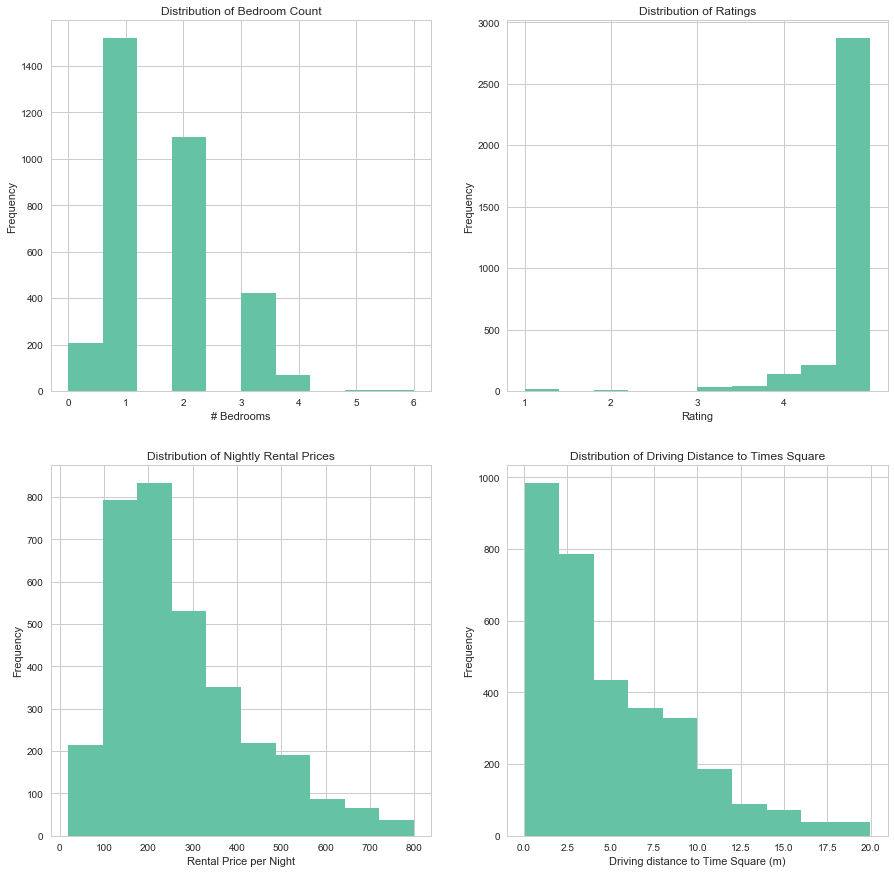

In [9]:
# # Not all rentals have reviews
df_with_reviews = df[df.rating.notnull()]

# Plot some basic graphs to understand the data
fig_overview, ax_overview = plt.subplots(2, 2, figsize=(15, 15))

ax_overview[0][0].hist(df.bedrooms.as_matrix())
ax_overview[0][0].set_title('Distribution of Bedroom Count')
ax_overview[0][0].set_xlabel('# Bedrooms')
ax_overview[0][0].set_ylabel('Frequency')

ax_overview[0][1].hist(df_with_reviews.rating.as_matrix())
ax_overview[0][1].set_title('Distribution of Ratings')
ax_overview[0][1].set_xlabel('Rating')
ax_overview[0][1].set_ylabel('Frequency')
ax_overview[0][1].xaxis.set_ticks(np.arange(1,5,1))

ax_overview[1][0].hist(df.price.as_matrix())
ax_overview[1][0].set_title('Distribution of Nightly Rental Prices')
ax_overview[1][0].set_xlabel('Rental Price per Night')
ax_overview[1][0].set_ylabel('Frequency')

ax_overview[1][1].hist(df.distance_to_TS.as_matrix())
ax_overview[1][1].set_title('Distribution of Driving Distance to Times Square')
ax_overview[1][1].set_xlabel('Driving distance to Time Square (m)')
ax_overview[1][1].set_ylabel('Frequency')

In [10]:
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,floor_area,distance_to_TS_meter,distance_to_TS
count,3318.000000,3318.000000,3318.000000,3318.000000,3318.00000,3318.000000,3318.000000,3318.000000,3318.000000,3318.000000,3318.000000,3318.000000
mean,272.600362,40.743015,-73.972683,4.704702,6.81314,4.439421,1.593128,1.191983,9.832128,832.870253,8089.724834,5.026720
std,153.916216,0.046023,0.048151,0.412485,16.69527,1.781163,0.882743,0.447654,12.282887,407.842053,6699.676748,4.162985
min,19.000000,40.571015,-74.257572,1.000000,0.00000,1.000000,0.000000,1.000000,1.000000,0.000000,51.000000,0.031690
25%,155.000000,40.717661,-73.992541,4.800000,0.00000,3.000000,1.000000,1.000000,2.000000,650.000000,2827.000000,1.756616
50%,235.000000,40.745754,-73.979146,4.800000,0.00000,4.000000,1.000000,1.000000,3.000000,700.000000,5759.000000,3.578476
75%,356.000000,40.767439,-73.952427,4.800000,4.00000,6.000000,2.000000,1.000000,14.000000,900.000000,11685.000000,7.260720
max,799.000000,40.974511,-73.712820,5.000000,175.00000,9.000000,6.000000,4.000000,90.000000,5000.000000,32177.000000,19.993855


In [11]:
# Heat map of prices in New York City
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])
locations = df.loc[:, ['geo_lat', 'geo_long']]
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations, weights=df["price"])
fig.add_layer(heatmap_layer)
fig


Widget Javascript not detected.  It may not be installed or enabled properly.


In [12]:
# Get a sense for how features correlate with price
features = ['rating', 'number_reviews', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
            'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
            'distance_to_TS', 'text_onefinestay', 'text_master', 'text_requests', 'text_advance']
X = df.loc[:, features]
y = df['price']

df.corr()['price'][features].sort_values()

distance_to_TS     -0.387495
min_stay           -0.212299
number_reviews     -0.073466
has_pool            0.018667
has_patio           0.045960
has_concierge       0.082604
rating              0.088019
has_elevator        0.189843
text_requests       0.198916
text_advance        0.245500
text_master         0.280883
floor_area          0.283151
text_onefinestay    0.315091
sleeps              0.376403
bathrooms           0.389518
bedrooms            0.397260
Name: price, dtype: float64

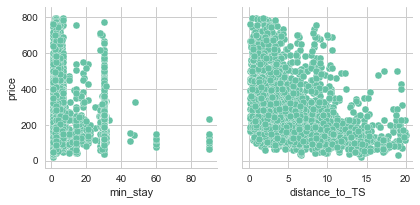

In [13]:
sns.pairplot(data=df, y_vars=['price'], x_vars=['min_stay', 'distance_to_TS'], size=3, aspect=1)

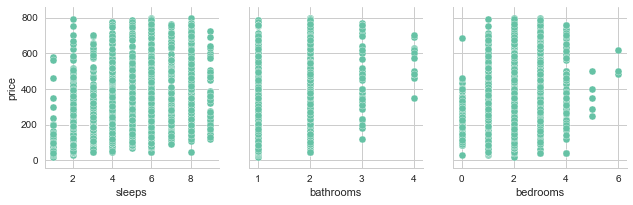

In [14]:
sns.pairplot(data=df, y_vars=['price'], x_vars=['sleeps', 'bathrooms', 'bedrooms'], size=3, aspect=1)

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

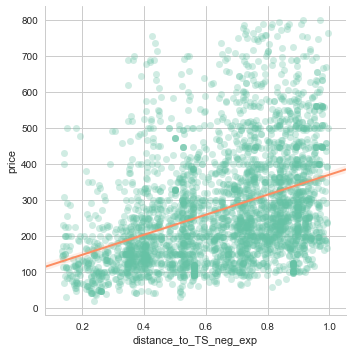

In [15]:
# Improve 'distance_to_TS' and 'number_reviews' features
df['distance_to_TS_neg_exp'] = df['distance_to_TS'].map(lambda d: (np.exp(d * -0.1)))
df['number_reviews_neg_exp'] = df['number_reviews'].map(lambda d: (np.exp(d * -0.02)))

# Improve correlation scores slightly
df.corr()['price'][['number_reviews_neg_exp', 'distance_to_TS_neg_exp']]
sns.lmplot(data=df, y='price', x='distance_to_TS_neg_exp', 
           palette="muted", scatter_kws={'alpha':.3}, line_kws={'lw':2, 'color': '#fc8d62'})
current_palette = sns.color_palette()
current_palette.as_hex()

## Multiple Linear Regression with # Bedrooms and Distance from Times Square

In [16]:
# Helper functions
def print_error(title, y_test, y_predict_test):
    print ('Errors for ', title, ':')
    print ("RMSE:", np.sqrt(mean_squared_error(y_test, y_predict_test)))
    print ("MAE:", mean_absolute_error(y_test, y_predict_test))
    print ("R2:", r2_score(y_test, y_predict_test))
    
def order_zip_coeff(coeff_names, coeff_vals):
    coeff_names = np.array(coeff_names)
    coeff_vals = np.array(coeff_vals)
    importance_indices = np.argsort(coeff_vals)[::-1]
    return list(zip(coeff_names[importance_indices], coeff_vals[importance_indices]))

# Split the data 70-30 train/test
features = features + ['number_reviews_neg_exp', 'distance_to_TS_neg_exp']
X = df.loc[:, features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
features_2 = ['bedrooms', 'distance_to_TS_neg_exp']
lr_model2 = LinearRegression()
lr_model2.fit(X_train.loc[:, features_2], y_train)
order_zip_coeff(features_2, lr_model2.coef_)

[('distance_to_TS_neg_exp', 320.45878758389273),
 ('bedrooms', 80.899850127285177)]

In [18]:
y_test_pred2 = lr_model2.predict(X_test.loc[:, features_2])
print_error('Multiple Linear Regression with 2 variables', y_test, y_test_pred2)

Errors for  Multiple Linear Regression with 2 variables :
RMSE: 121.293920787
MAE: 93.4849742985
R2: 0.370481046393


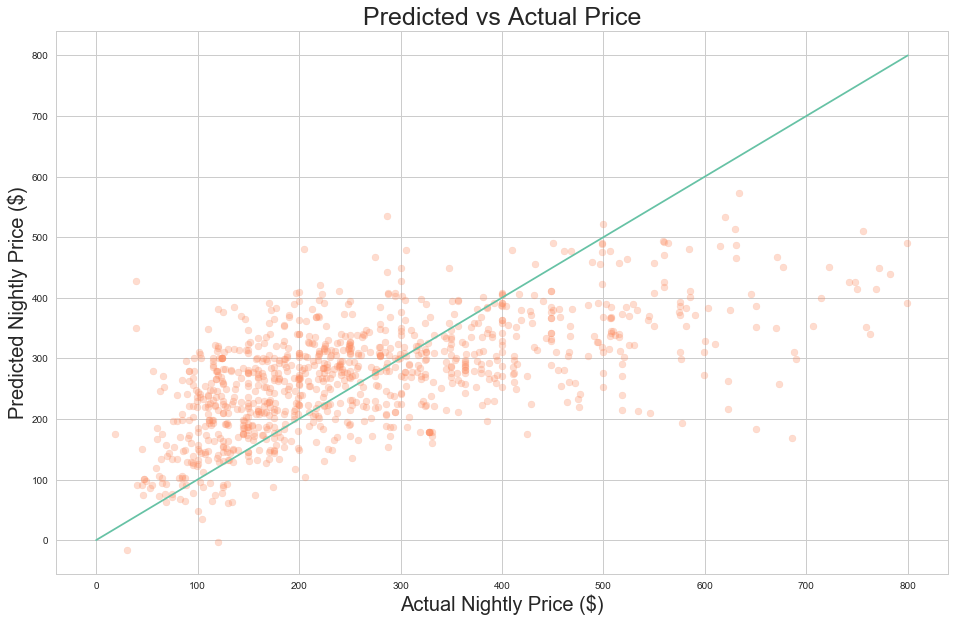

In [53]:
## Plot predicted price vs actual price
plt.xlabel('Actual Nightly Price ($)', fontsize=20)
plt.ylabel('Predicted Nightly Price ($)', fontsize=20)
plt.scatter(y_test, y_test_pred2,  alpha=.3, color=sns.color_palette()[1])
plt.title('Predicted vs Actual Price', fontsize=25)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 800, 10))

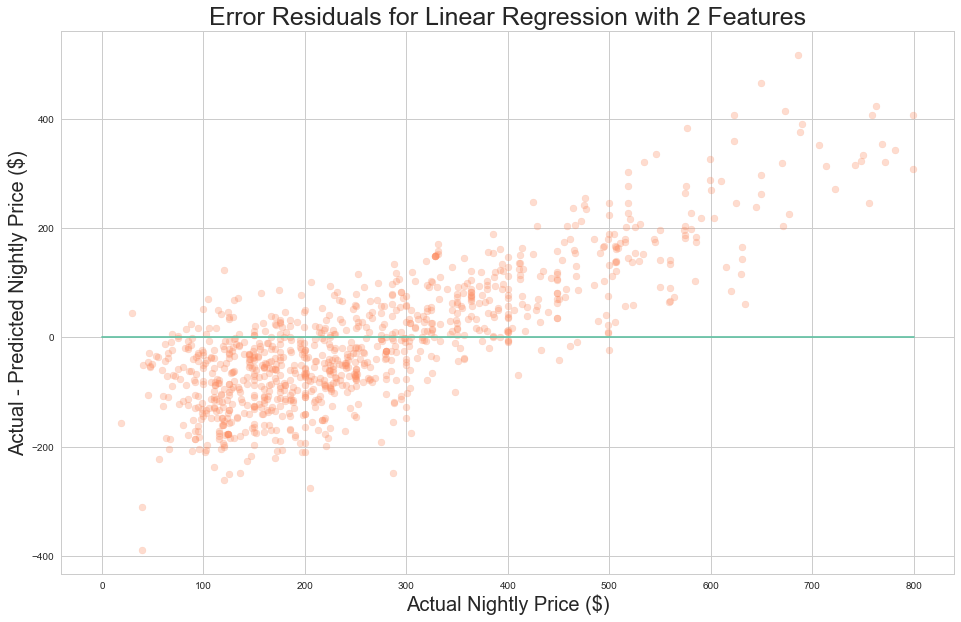

In [54]:
## Residual Plot
plt.scatter(y_test, y_test - y_test_pred2, alpha=.3, color=sns.color_palette()[1])
plt.title('Error Residuals for Linear Regression with 2 Features', fontsize=25)
plt.xlabel('Actual Nightly Price ($)', fontsize=20)
plt.ylabel('Actual - Predicted Nightly Price ($)', fontsize=20)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 0, 10))

## Multiple Linear Regression with 4 variables

In [21]:
features_4 = ['bedrooms', 'bathrooms',
              'min_stay', 'distance_to_TS_neg_exp']
lr_model_4 = LinearRegression()
lr_model_4.fit(X_train.loc[:, features_4], y_train)
order_zip_coeff(features_4, lr_model_4.coef_)

[('distance_to_TS_neg_exp', 354.05612912637417),
 ('bathrooms', 89.55933168167482),
 ('bedrooms', 58.086563938178188),
 ('min_stay', -3.3193272671430378)]

In [22]:
y_test_pred4 = lr_model_4.predict(X_test.loc[:, features_4])
print_error('Multiple Linear Regression with 4 variables', y_test, y_test_pred4)

Errors for  Multiple Linear Regression with 4 variables :
RMSE: 105.935959882
MAE: 81.138871521
R2: 0.519805089064


## Multiple Linear Regression with all variables

In [23]:
features_all = ['rating', 'number_reviews_neg_exp', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
               'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
               'distance_to_TS_neg_exp', 'text_onefinestay', 'text_master', 'text_requests', 'text_advance']
lr_model_all = LinearRegression()
lr_model_all.fit(X_train.loc[:, features_all], y_train)
order_zip_coeff(features_all, lr_model_all.coef_)

[('distance_to_TS_neg_exp', 338.4955379290551),
 ('text_onefinestay', 210.52446862733311),
 ('bathrooms', 63.528417992034662),
 ('number_reviews_neg_exp', 60.449420701778998),
 ('bedrooms', 35.357037887140379),
 ('rating', 34.342562774200516),
 ('text_master', 30.715218843865266),
 ('has_concierge', 19.265443922179884),
 ('has_elevator', 18.909547409865539),
 ('has_pool', 14.01966431069993),
 ('text_advance', 12.445036739733524),
 ('sleeps', 11.857676149127423),
 ('has_patio', 1.1565668546617367),
 ('floor_area', 0.01627487046860665),
 ('min_stay', -3.3190134988215902),
 ('text_requests', -21.339585918830181)]

In [24]:
y_test_pred_all = lr_model_all.predict(X_test.loc[:, features_all])
print_error('Multiple Linear Regression with all variables', y_test, y_test_pred_all)

Errors for  Multiple Linear Regression with all variables :
RMSE: 96.6503124453
MAE: 73.0005394411
R2: 0.600297130923


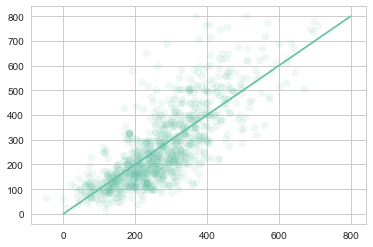

In [25]:
## Plot predicted price vs actual price
plt.scatter(y_test_pred_all, y_test, alpha=.1)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 800, 10))

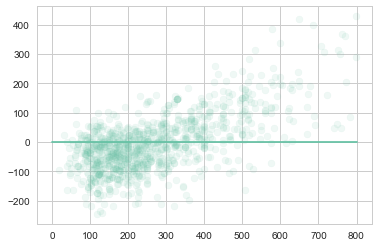

In [26]:
## Residual Plot
plt.scatter(y_test, y_test - y_test_pred_all, alpha=.1)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 0, 10))

## Lasso Regression

In [27]:
# First standardize features
std = StandardScaler()
std.fit(X_train.loc[:, features_all])

# Model should be something you calculate without looking at test set
X_std_train = std.transform(X_train.loc[:, features_all])
X_std_test = std.transform(X_test.loc[:, features_all])

alphavec = 10**np.linspace(-5,9,1000)
lasso_model = LassoCV(alphas = alphavec, cv=5, selection='random')
lasso_model.fit(X_std_train, y_train)
print('Best alpha: ', lasso_model.alpha_)

Best alpha:  0.347168681893


In [28]:
ordered_lasso_coeff = order_zip_coeff(features_all, lasso_model.coef_)
ordered_lasso_coeff

[('distance_to_TS_neg_exp', 73.585136695519964),
 ('text_onefinestay', 37.511161487436461),
 ('bedrooms', 31.502439064678313),
 ('bathrooms', 29.054543598233106),
 ('sleeps', 21.18944023522748),
 ('rating', 13.219572693417437),
 ('number_reviews_neg_exp', 10.934392482102528),
 ('text_master', 10.280905627171432),
 ('has_elevator', 8.4654503444200557),
 ('floor_area', 6.6739825580515948),
 ('has_concierge', 5.9652969380588168),
 ('has_pool', 3.1284760581991047),
 ('text_advance', 2.6711032036886384),
 ('has_patio', 0.14507305113174743),
 ('text_requests', -5.0636059140854695),
 ('min_stay', -40.22670873281394)]

In [29]:
y_test_pred_lasso = lasso_model.predict(X_std_test)
print_error('Lasso Regression', y_test, y_test_pred_lasso)

Errors for  Lasso Regression :
RMSE: 96.646765548
MAE: 73.0073739438
R2: 0.600326467176


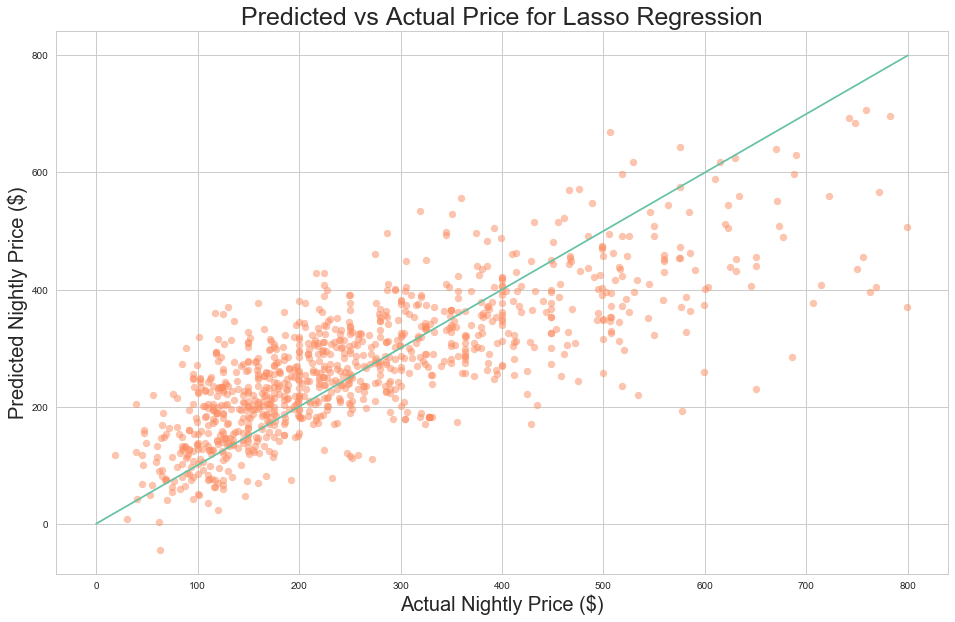

In [55]:
## Plot predicted price vs actual price
plt.xlabel('Actual Nightly Price ($)', fontsize=20)
plt.ylabel('Predicted Nightly Price ($)', fontsize=20)
plt.scatter(y_test, y_test_pred_lasso,  alpha=.5, color=sns.color_palette()[1])
plt.title('Predicted vs Actual Price for Lasso Regression', fontsize=25)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 800, 10))

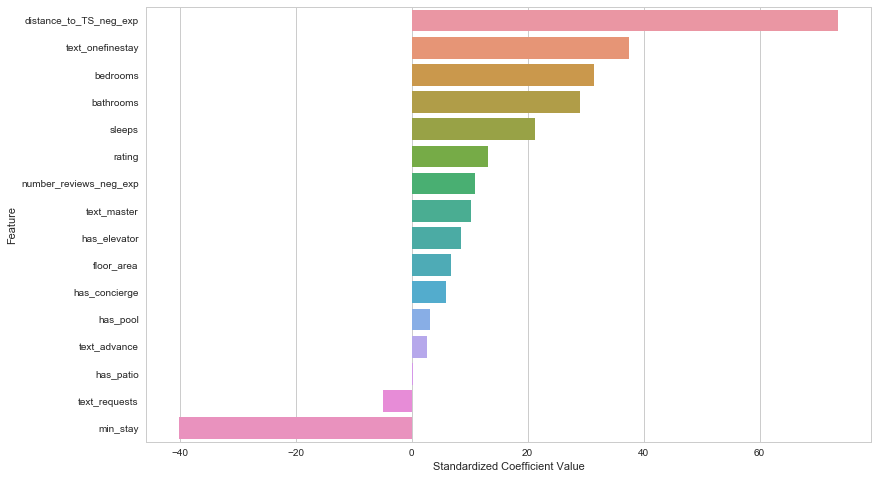

In [31]:
# Visualizing magnitude of lasso coefficients
plt.rcParams['figure.figsize']=(13,8)
df_lasso = pd.DataFrame({'coefficients': lasso_model.coef_, 'features': features_all})
sns.barplot(x="coefficients", y="features", data=df_lasso, order=[c[0] for c in ordered_lasso_coeff])
plt.xlabel('Standardized Coefficient Value')
plt.ylabel('Feature')

## Multiple Linear Regresion with top 6 important features

In [32]:
features_top = ['bedrooms', 'bathrooms', 'min_stay', 'sleeps',
                'distance_to_TS_neg_exp', 'text_onefinestay']
lr_model_top = LinearRegression()
lr_model_top.fit(X_train.loc[:, features_top], y_train)
order_zip_coeff(features_top, lr_model_top.coef_)

[('distance_to_TS_neg_exp', 354.89001915097725),
 ('text_onefinestay', 229.79010414632987),
 ('bathrooms', 73.988475597039752),
 ('bedrooms', 44.544610398858154),
 ('sleeps', 9.8751596711436704),
 ('min_stay', -3.0181798530273198)]

In [33]:
y_test_pred_top = lr_model_top.predict(X_test.loc[:, features_top])
print_error('Multiple Linear Regression with top 6 features', y_test, y_test_pred_top)

Errors for  Multiple Linear Regression with top 6 features :
RMSE: 99.5477981784
MAE: 76.3437033341
R2: 0.575972465913


## Single Decision Tree

In [34]:
features_all_tree = np.array(['number_reviews_neg_exp', 'sleeps', 'bedrooms', 'bathrooms', 'min_stay',
                   'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area',
                   'distance_to_TS_neg_exp', 'geo_lat', 'geo_long',
                   'text_onefinestay', 'text_master', 'text_requests', 'text_advance'])
X_tree = df.loc[:, features_all_tree]

# Split the data 70-30 train/test
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.3, random_state=42)

# Build a deep tree to see which freatures are important

dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=20, min_samples_leaf=8)
dtrmodel.fit(X_train_tree, y_train)
tree.export_graphviz(dtrmodel, out_file='tree.dot', feature_names=X_train_tree.columns)

!head tree.dot

digraph Tree {
node [shape=box] ;
0 [label="bathrooms <= 1.5\nmse = 23791.8903\nsamples = 2322\nvalue = 275.3514"] ;
1 [label="distance_to_TS_neg_exp <= 0.6822\nmse = 17774.3486\nsamples = 1910\nvalue = 247.733"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="bedrooms <= 1.5\nmse = 10513.0103\nsamples = 886\nvalue = 188.9537"] ;
1 -> 2 ;
3 [label="distance_to_TS_neg_exp <= 0.4471\nmse = 7238.9271\nsamples = 480\nvalue = 156.9354"] ;
2 -> 3 ;
4 [label="sleeps <= 1.5\nmse = 2116.6018\nsamples = 219\nvalue = 121.4338"] ;


In [35]:
order_zip_coeff(features_all_tree, dtrmodel.feature_importances_)

[('distance_to_TS_neg_exp', 0.24085287963451835),
 ('bathrooms', 0.19483456343881822),
 ('min_stay', 0.16289900449715469),
 ('bedrooms', 0.08677412049590473),
 ('geo_long', 0.071418483320399448),
 ('text_onefinestay', 0.053513131829446753),
 ('floor_area', 0.044171403252614073),
 ('number_reviews_neg_exp', 0.035735243698611488),
 ('geo_lat', 0.034775171893696222),
 ('sleeps', 0.031566398134176998),
 ('has_concierge', 0.017517003582645164),
 ('text_master', 0.013460538823338473),
 ('has_elevator', 0.0056214238944239606),
 ('text_advance', 0.0044112490979991885),
 ('has_patio', 0.0020021976528770634),
 ('text_requests', 0.00044718675337535285),
 ('has_pool', 0.0)]

In [36]:
y_test_pred_decision = dtrmodel.predict(X_test_tree)
print_error('Single Decision Tree', y_test, y_test_pred_decision)

Errors for  Single Decision Tree :
RMSE: 99.366274412
MAE: 70.5963690565
R2: 0.577517470398


## Random Forest

In [74]:
# Run one time to get best results
grid_parameters_rf = {'max_features': np.arange(3, 7, 1),
                      'min_samples_leaf': [10],
                      'max_depth': np.arange(4, 8, 1),
                      'n_estimators':[1000, 5000]}

lr_model_rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(lr_model_rf, grid_parameters_rf, n_jobs=-2, verbose=1)
#grid_search_rf.fit(X_train_tree, y_train)

"""
grid_search_rf.best_params_:

{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 10,
 'n_estimators': 5000}
"""
#grid_search_rf.best_params_


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-2)]: Done  96 out of  96 | elapsed:  3.0min finished


{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 10,
 'n_estimators': 5000}

In [38]:
# Use best parameters found above in Random Forest Grid Search
lr_model_rf_best = RandomForestRegressor(n_estimators=5000, min_samples_leaf=10, max_depth=7,
                                         max_features=6, n_jobs=-1)
lr_model_rf_best.fit(X_train_tree, y_train)
order_zip_coeff(features_all_tree, lr_model_rf_best.feature_importances_)

[('distance_to_TS_neg_exp', 0.23550806569539817),
 ('bathrooms', 0.13135798828044326),
 ('bedrooms', 0.12565760072934679),
 ('geo_long', 0.11240346263078124),
 ('min_stay', 0.10151803239361214),
 ('sleeps', 0.072004272913284331),
 ('text_onefinestay', 0.054303025203578138),
 ('floor_area', 0.045878211822519124),
 ('geo_lat', 0.042929585399436559),
 ('number_reviews_neg_exp', 0.019187189777776316),
 ('text_advance', 0.018051786632464643),
 ('text_master', 0.017396948093500845),
 ('has_elevator', 0.0089935829158640131),
 ('text_requests', 0.0086811132003973453),
 ('has_concierge', 0.0050367784515172537),
 ('has_patio', 0.00070892719597343023),
 ('has_pool', 0.00038342866410651111)]

In [39]:
y_test_pred_rf = lr_model_rf_best.predict(X_test_tree)
print_error('Random Forest', y_test, y_test_pred_rf)

Errors for  Random Forest :
RMSE: 88.4355569638
MAE: 66.7948867468
R2: 0.665354821884


## Gradient Boosted Tree

In [75]:
# Run one time to get best results
grid_parameters_gb = {'max_depth':[5, 6, 7],
                      'learning_rate':np.arange(.01,.1,.01),
                      'n_estimators':[500]}

gbmodel_grid = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(gbmodel_grid, grid_parameters_gb, n_jobs=-2, verbose=1)
grid_search_gb.fit(X_train_tree, y_train)

"""
grid_search_rf.best_params_:
{'learning_rate': 0.029999999999999999, 
'max_depth': 5, 
'n_estimators': 500}
"""
grid_search_gb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed:   28.8s finished


{'learning_rate': 0.029999999999999999, 'max_depth': 5, 'n_estimators': 500}

In [76]:
gbmodel1 = GradientBoostingRegressor(learning_rate=0.03, max_depth=5, n_estimators=500)
gbmodel1.fit(X_train_tree, y_train)

ordered_gb_coeff = order_zip_coeff(features_all_tree, gbmodel1.feature_importances_)
ordered_gb_coeff

[('distance_to_TS_neg_exp', 0.23326956229062909),
 ('geo_long', 0.2153510962045764),
 ('geo_lat', 0.1623753505253967),
 ('floor_area', 0.077326945163956481),
 ('min_stay', 0.067904501549613722),
 ('sleeps', 0.058781153830432038),
 ('number_reviews_neg_exp', 0.038734836695304399),
 ('bathrooms', 0.033331713408829865),
 ('bedrooms', 0.033237873017032675),
 ('has_concierge', 0.015417139483016118),
 ('text_onefinestay', 0.014668923680794468),
 ('has_elevator', 0.014530862490153073),
 ('text_master', 0.011144865789027377),
 ('text_advance', 0.0064145001468241779),
 ('has_pool', 0.0060065671310549117),
 ('has_patio', 0.0059558266344063408),
 ('text_requests', 0.0055482819589523086)]

In [77]:
y_test_pred_gb1 = gbmodel1.predict(X_test_tree)
print_error('Gradient Boosted Tree', y_test, y_test_pred_gb1)

Errors for  Gradient Boosted Tree :
RMSE: 79.9340968267
MAE: 55.7975645181
R2: 0.726602281871


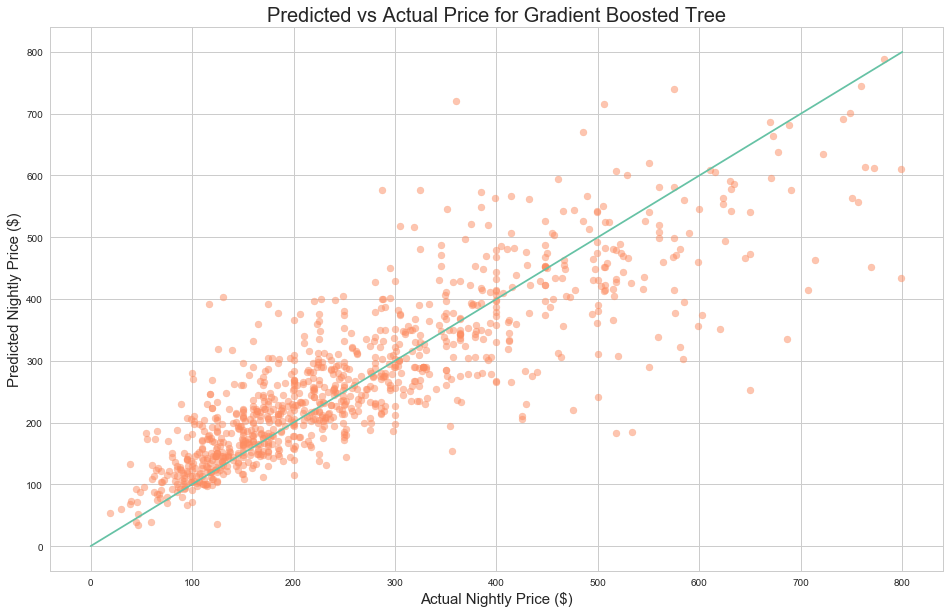

In [78]:
## Plot predicted price vs actual price
plt.xlabel('Actual Nightly Price ($)', fontsize=15)
plt.ylabel('Predicted Nightly Price ($)', fontsize=15)
plt.scatter(y_test, y_test_pred_gb1,  alpha=.5, color=sns.color_palette()[1])
plt.title('Predicted vs Actual Price for Gradient Boosted Tree', fontsize=20)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 800, 10))

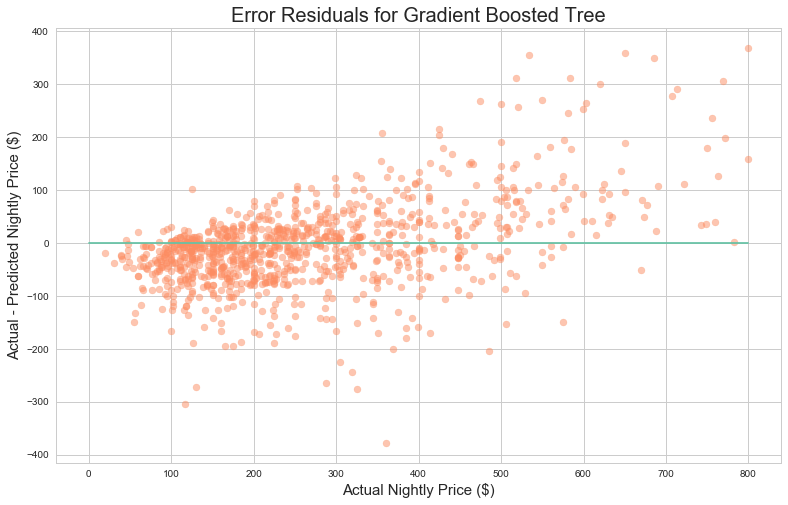

In [47]:
## Residual Plot
plt.scatter(y_test, y_test - y_test_pred_gb1, alpha=.5, color=sns.color_palette()[1])
plt.title('Error Residuals for Gradient Boosted Tree', fontsize=20)
plt.xlabel('Actual Nightly Price ($)', fontsize=15)
plt.ylabel('Actual - Predicted Nightly Price ($)', fontsize=15)
plt.plot(np.linspace(0, 800, 10), np.linspace(0, 0, 10))


### Compare Gradient Boosting and Random Forest

In [81]:
df_gb_coeff = pd.DataFrame({'feature': features_all_tree,
                            'importance': gbmodel1.feature_importances_,
                            'model': ['Gradient Boosted Tree'] * len(features_all_tree)})

df_rf_coeff = pd.DataFrame({'feature': features_all_tree,
                            'importance': lr_model_rf_best.feature_importances_,
                            'model': ['Random Forest'] * len(features_all_tree)})
df_coeff_combined = df_gb_coeff.append(df_rf_coeff)

top_features_gb = [c[0] for c in ordered_gb_coeff][0:6]
top_features_gb

['distance_to_TS_neg_exp',
 'geo_long',
 'geo_lat',
 'floor_area',
 'min_stay',
 'sleeps',
 'number_reviews_neg_exp',
 'bathrooms',
 'bedrooms',
 'has_concierge',
 'text_onefinestay',
 'has_elevator',
 'text_master',
 'text_advance',
 'has_pool',
 'has_patio',
 'text_requests']

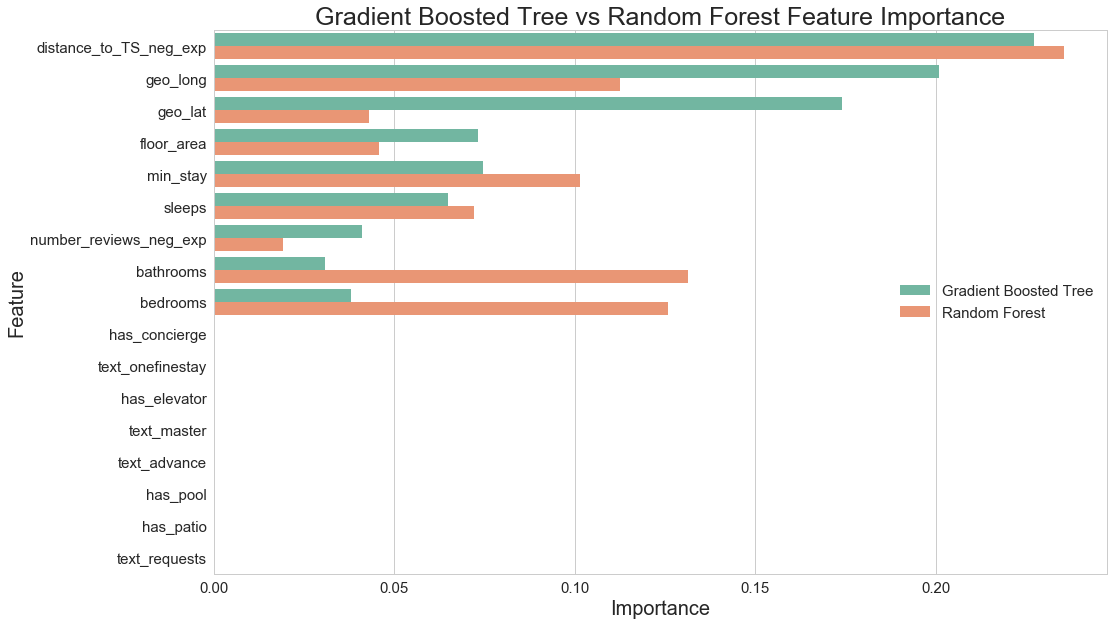

In [82]:
# Visualize feature importance
plt.rcParams['figure.figsize']=(16,10)
sns.barplot(x='importance', y='feature', hue='model', data=df_coeff_combined_top, 
            palette="Set2",
            order=top_features_gb)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 15})
plt.ylabel('Feature', fontsize=20)
plt.xlabel('Importance', fontsize=20)
plt.title('Gradient Boosted Tree vs Random Forest Feature Importance', fontsize=25);